#  Extracting summary statistics and performing Bayesian inference

This example is based on https://github.com/tomcharnock/information_maximiser/blob/v2/IMNN%20(1D).ipynb by Tom Charnock and demonstrate that training a summary statistic for inference by maximum likelihood yields similar results to  maximising the Fisher information.

In [17]:
%pylab inline
import os
import tensorflow as tf
import tensorflow.contrib.slim as slim
import tensorflow_probability
tfd = tensorflow_probability.distributions

Populating the interactive namespace from numpy and matplotlib


In [3]:
def _mdn_model_fn(features, labels, network_fn, n_mixture, diag,
               feature_columns, label_columns, optimizer, activation_fn, normalizer_fn, dropout, mode):

    # Check for training mode
    is_training = mode == tf.estimator.ModeKeys.TRAIN
    label_dimension=len(label_columns)

    # Extracts the features
    input_layer = features
    regularizer = slim.l2_regularizer(0.0001)

    # Builds the neural network
    net = slim.fully_connected(input_layer, 128, activation_fn=tf.nn.leaky_relu)
    net = slim.fully_connected(net, 128, activation_fn=tf.nn.leaky_relu)
    
    # Summary statistics of the signal
    stat = slim.fully_connected(net, 1, activation_fn=None, weights_regularizer=regularizer)
    
    net = slim.fully_connected(stat, 64, activation_fn=tf.nn.tanh)
    
    
    # Size of the covariance matrix
    if diag ==True:
        size_sigma = label_dimension
    else:
        size_sigma = (label_dimension *(label_dimension +1) // 2)
        
    # Create mixture components from network output
    out_mu = slim.fully_connected(net, label_dimension*n_mixture , activation_fn=None)
    out_mu = tf.reshape(out_mu, (-1, n_mixture, label_dimension))

    out_sigma = slim.fully_connected(net, size_sigma * n_mixture, activation_fn=None)
    out_sigma = tf.reshape(out_sigma, (-1, n_mixture, size_sigma))

    out_p = slim.fully_connected(net, n_mixture, activation_fn=None)

    if diag == True:
        sigma_mat = tf.nn.softplus(out_sigma)+1e-4
        gmm = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(logits=out_p),
                      components_distribution=tfd.MultivariateNormalDiag(loc=out_mu,
                                                                        scale_diag=sigma_mat))
    else:
        sigma_mat = tfd.matrix_diag_transform(tfd.fill_triangular(out_sigma), transform=tf.nn.softplus)
        gmm = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(logits=out_p),
                     components_distribution=tfd.MultivariateNormalTriL(loc=out_mu,
                                                                        scale_tril=sigma_mat))

    predictions = {'mu': out_mu, 'sigma': sigma_mat, 'p':out_p, 'stat':stat}

    if mode == tf.estimator.ModeKeys.PREDICT:
        y = gmm.sample(2000)
        samples = y
        predictions['samples'] = tf.transpose(y,[1,0,2])

        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions,
                                          export_outputs={'pdf': tf.estimator.export.PredictOutput(predictions),
                                                          'samples': tf.estimator.export.PredictOutput(samples),
                                                          tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY: tf.estimator.export.PredictOutput(samples)})

    label_layer = labels

    # Compute and register loss function
    loss = - tf.reduce_mean(gmm.log_prob(label_layer),axis=0)
    tf.losses.add_loss(loss)
    total_loss = tf.losses.get_total_loss(add_regularization_losses=True)

    train_op = None
    eval_metric_ops = None

    # Define optimizer
    if mode == tf.estimator.ModeKeys.TRAIN:
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            train_op = optimizer(learning_rate=0.0002).minimize(loss=total_loss,
                                        global_step=tf.train.get_global_step())
        tf.summary.scalar('loss', loss)
    elif mode == tf.estimator.ModeKeys.EVAL:
        eval_metric_ops = { "log_p": loss}

    return tf.estimator.EstimatorSpec(mode=mode,
                                      predictions=predictions,
                                      loss=total_loss,
                                      train_op=train_op,
                                      eval_metric_ops=eval_metric_ops)

class MDNEstimator(tf.estimator.Estimator):
    """An estimator for distribution estimation using Mixture Density Networks.
    """

    def __init__(self,
               feature_columns,
               label_columns,
               network_fn,
               n_mixture,
               diagonal=True,
               optimizer=tf.train.AdamOptimizer,
               activation_fn=tf.nn.relu,
               normalizer_fn=slim.batch_norm,
               dropout=None,
               model_dir=None,
               config=None):
        """Initializes a `MDNEstimator` instance.
        """

        def _model_fn(features, labels, mode):
            return _mdn_model_fn(features, labels, network_fn, n_mixture, diagonal,
               feature_columns, label_columns, optimizer, activation_fn, normalizer_fn, dropout, mode)

        super(self.__class__, self).__init__(model_fn=_model_fn,
                                             model_dir=model_dir,
                                             config=config)

In [4]:
# Define input function for estimator
batch_size = 256

# Number of training and testing simulations
nsims_train = 100000
nsims_test = 100000

# Samples from the prior U[0,10]
t_train = 10 * rand(nsims_train,1)
t_test = 10 * rand(nsims_test,1)

# Set the 10 first test parameters to 1
t_test[0:10] = 1.0

x_train = sqrt(t_train) * randn(nsims_train,10)
x_test = sqrt(t_test) * randn(nsims_test,10)

def _prior_sampling_input_fn():
    """Serving input fn for training data"""
    dataset = tf.data.Dataset.from_tensor_slices((x_train.astype('float32'), t_train.astype('float32')))
    dataset = dataset.repeat().shuffle(1000).batch(batch_size)
    return dataset

def _testing_input_fn():
    """Serving input fn for testing data"""
    dataset = tf.data.Dataset.from_tensor_slices((x_test.astype('float32'), t_test.astype('float32')))
    dataset = dataset.batch(batch_size)
    return dataset

In [5]:
features = ['x']
labels = ['theta']

model = MDNEstimator(features, labels, None, n_mixture=16,
               diagonal=True, model_dir='models/model1')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'models/model1', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f3b6705ec88>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [6]:
model.train(_prior_sampling_input_fn, max_steps=10000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into models/model1/model.ckpt.
INFO:tensorflow:loss = 27.72662, step = 0
INFO:tensorflow:global_step/sec: 134.165
INFO:tensorflow:loss = 4.2680726, step = 100 (0.748 sec)
INFO:tensorflow:global_step/sec: 290.848
INFO:tensorflow:loss = 2.6327562, step = 200 (0.340 sec)
INFO:tensorflow:global_step/sec: 212.868
INFO:tensorflow:loss = 2.4562826, step = 300 (0.471 sec)
INFO:tensorflow:global_step/sec: 242.457
INFO:tensorflow:loss = 2.3053944, step = 400 (0.412 sec)
INFO:tensorflow:global_step/sec: 339.658
INFO:tensorflow:loss = 2.1668622, step = 500 (0.294 sec)
INFO:tensorflow:global_step/sec: 111.694
INFO:tensorflow:loss = 2.1191227, step = 600 (0.900 sec)
INFO:tensorflow:global_step/sec: 109.933
INFO:tensorflow:loss

INFO:tensorflow:global_step/sec: 257.289
INFO:tensorflow:loss = 1.6089286, step = 8100 (0.384 sec)
INFO:tensorflow:global_step/sec: 175.428
INFO:tensorflow:loss = 1.6466559, step = 8200 (0.570 sec)
INFO:tensorflow:global_step/sec: 316.083
INFO:tensorflow:loss = 1.5424924, step = 8300 (0.316 sec)
INFO:tensorflow:global_step/sec: 201.677
INFO:tensorflow:loss = 1.5765532, step = 8400 (0.497 sec)
INFO:tensorflow:global_step/sec: 296.86
INFO:tensorflow:loss = 1.54961, step = 8500 (0.336 sec)
INFO:tensorflow:global_step/sec: 339.172
INFO:tensorflow:loss = 1.6493255, step = 8600 (0.294 sec)
INFO:tensorflow:global_step/sec: 353.334
INFO:tensorflow:loss = 1.6134937, step = 8700 (0.284 sec)
INFO:tensorflow:global_step/sec: 322.279
INFO:tensorflow:loss = 1.6448605, step = 8800 (0.310 sec)
INFO:tensorflow:global_step/sec: 348.298
INFO:tensorflow:loss = 1.5939113, step = 8900 (0.288 sec)
INFO:tensorflow:global_step/sec: 285.75
INFO:tensorflow:loss = 1.6508124, step = 9000 (0.350 sec)
INFO:tensorflo

In [7]:
pred = model.predict(_testing_input_fn)

In [8]:
# Compute the summary statistics and compares it to the optimal one
st = []
va = []

for i in range(10000):
    p =  next(pred)
    st.append(p['stat'])
    va.append(sum(x_test[i]**2))
    
st = array(st)
va = array(va)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/model1/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


(0, 100)

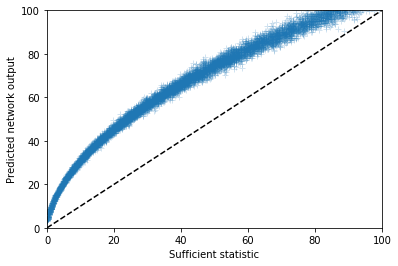

In [11]:
plot(va, -9*st, '+',alpha=0.2)
xlabel('Sufficient statistic')
ylabel('Predicted network output')
plot([0,100],[0,100],'k--')
xlim(0,100)
ylim(0,100)

In [12]:
pred = model.predict(_testing_input_fn)
i=0

In [13]:
p = next(pred)
x = x_test[i]
t = t_test[i]
i = i + 1 

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/model1/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [14]:
real_data = x
θ_grid = np.linspace(0.001, 10, 1000)
analytic_posterior = np.exp(-0.5 * np.sum(real_data**2) / θ_grid) / np.sqrt(2. * np.pi * θ_grid)**10.
analytic_posterior = analytic_posterior / np.sum(analytic_posterior * (θ_grid[1] - θ_grid[0]))

/usr/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


(0, 10)

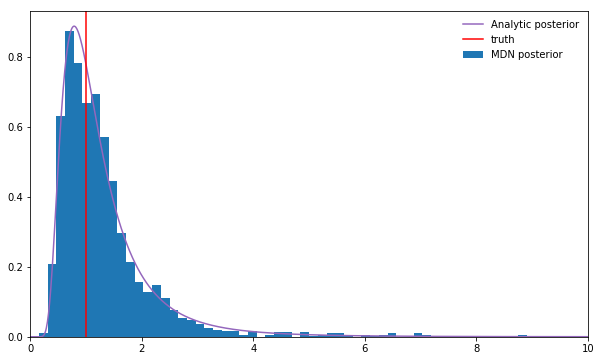

In [16]:
fig, ax = plt.subplots(1, 1, figsize = (10, 6))
ax.plot(θ_grid, analytic_posterior, linewidth = 1.5, color = 'C4', label = "Analytic posterior")
hist(p['samples'].flatten(),64,range=[0,10],normed=True, label='MDN posterior');

axvline(t,color='r', label='truth')
ax.legend(frameon = False)
ax.set_xlim([0, 10])